# Load Packages

In [1]:
import pandas as pd
import numpy as np
import json
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import ast
import os
from os import path
from pandas.plotting import table
import nltk
nltk.download("popular")
from google.colab import output
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
output.clear()

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
load_path = '/content/drive/MyDrive/NLP_Project/data/sentence_broken/'
word_df = pd.read_pickle(load_path + 'sentence_df.pkl')

# Seperate Words

In [4]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_words(sentences):

  collection = []
  for sent in sentences:
    words = word_tokenize(sent)

    # STEM
    # words = [ps.stem(w) for w in words]
    # words = [ps.stem(w) for w in words if w not in stopwords.words('english')]

    # LEMM
    words = [lemmatizer.lemmatize(w) for w in words if len(w)> 1]
    # print(words)
    # words = [lemmatizer.lemmatize(w) for w in words if w not in stopwords.words('english')]

    collection.extend(words)
    # break


  return collection

In [5]:
word_df['Description'] = word_df['Description'].apply(clean_words)

## Visualize word count for each tag

In [6]:
word_df['ULength'] = word_df['Description'].apply(set).apply(list).apply(len)

In [7]:
word_df['Length'] = word_df['Description'].apply(len)

In [8]:
popular_threshold = 12

def seperate_tags(input_df):

  def replace_tag(tags):
    new_tags = []
    for t in tags:
      if t == 'Sci-Fi':
        new_tags.append('Sci Fi')
      elif t == 'BL':
        new_tags.append('Yaoi')
      else:
        new_tags.append(t)

    return new_tags

  df = input_df.copy()
  df['Tags'] = df['Tags'].apply(ast.literal_eval)
  df['Tags'] = df['Tags'].apply(replace_tag)

  df = df.explode('Tags')

  group_df = df.groupby('Tags')

  b = df.groupby('Tags')['Length'].agg('sum').reset_index(name='Counts')
  b.sort_values(by=['Counts'], inplace=True, ascending=False)
  
  bb = df.groupby('Tags')['ULength'].agg('sum').reset_index(name='Unique Counts')
  bb.sort_values(by=['Unique Counts'], inplace=True, ascending=False)

  popular_tags = list(b['Tags'][:popular_threshold])
  
  tags = []
  values = []
  words = []
  counts = []
  unique_counts = []

  for tag, tag_df in group_df:
    if tag in popular_tags:
      # # if you want all words in a single list
      # dd = np.concatenate( tag_df['Description'].tolist())

      # if you want words of each document seperated
      dd = tag_df['Description'].values.tolist()
      res = np.concatenate(dd)
      ures = list(set(res))
      
      tags.append(tag)
      values.append(dd)
      words.append(res)
      counts.append(len(res))
      unique_counts.append(len(ures))


  # # create dataframe
  word_level_df = pd.DataFrame({'Genre': tags, 
                                'Description': values,
                                'Words': words,
                                'Counts' : counts,
                                'UCounts' : unique_counts
                                })
  
  all_genres_df = pd.DataFrame({'Genre': tags, 
                                'Count': counts})
  
  # plot counts
  g = all_genres_df.nlargest(columns="Count", n = 50) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=g, x= "Count", y = "Genre") 
  plt.savefig("Word-Count.png")
  plt.show()

  uall_genres_df = pd.DataFrame({'Genre': tags, 
                                'UCount': unique_counts})
  
  # plot unique word counts
  g = uall_genres_df.nlargest(columns="UCount", n = 50) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=g, x= "UCount", y = "Genre") 
  ax.set_xlabel('Unique Count')
  plt.savefig("Unique-Word-Count.png")
  plt.show()

  # return group_df, b
  return word_level_df, all_genres_df, uall_genres_df

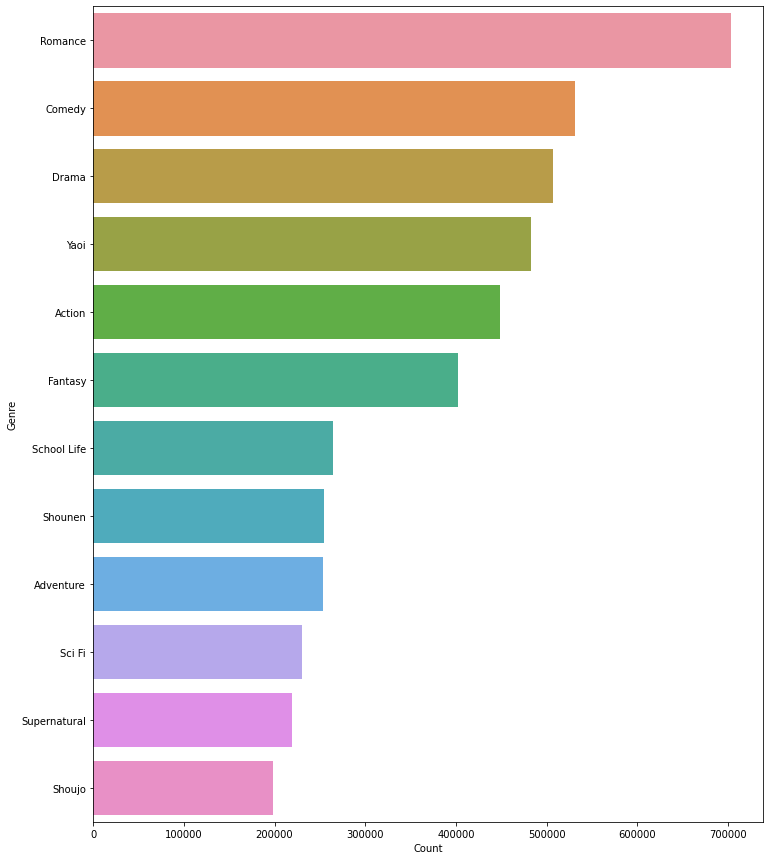

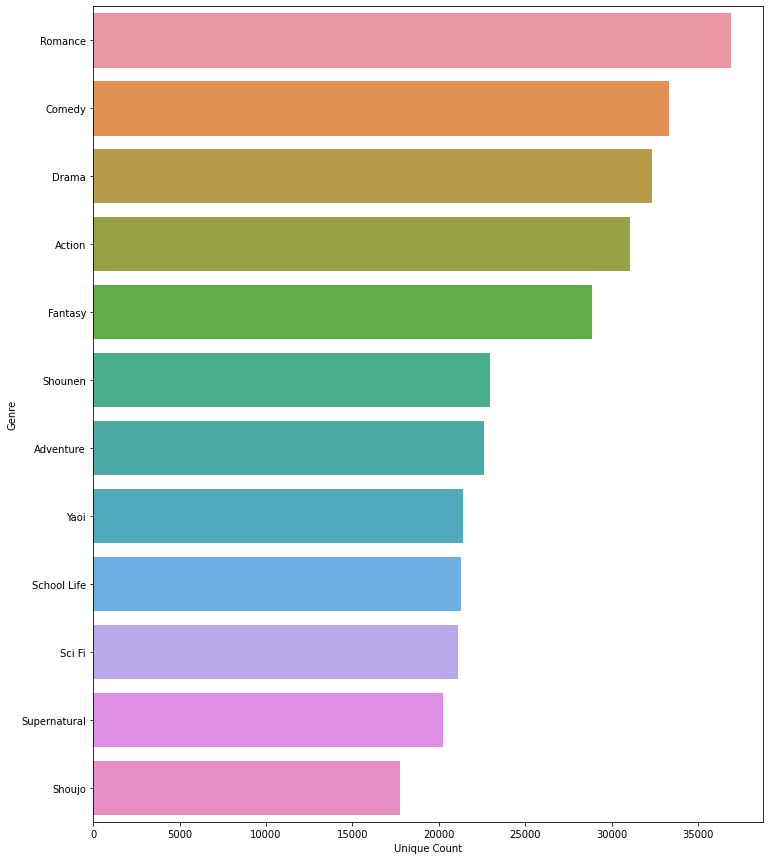

In [9]:
word_level_df, word_count_df, unique_word_count_df = seperate_tags(word_df)

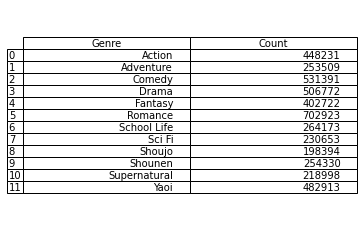

In [10]:
# word_count_df

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, word_count_df, loc='center')

plt.savefig('word_count_df.png', bbox_inches='tight')

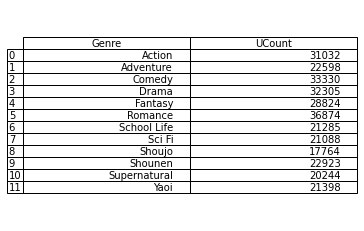

In [11]:
# unique_word_count_df

# word_count_df

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, unique_word_count_df, loc='center')  # where df is your data frame

plt.savefig('unique_word_count_df.png', bbox_inches='tight')

# Save Data

In [ ]:
save_path = '/content/drive/MyDrive/NLP_Project/data/word_broken/'
if not path.exists(save_path):
  os.mkdir(save_path)

# word_count_df.to_csv('word_count_df.csv')
# unique_word_count_df.to_csv('unique_word_count_df.csv')
# word_level_df.to_csv('word_level_df.csv')
# word_df.to_csv('word_df.csv')

word_count_df.to_pickle('word_count_df.pkl')
unique_word_count_df.to_pickle('unique_word_count_df.pkl')
word_level_df.to_pickle('word_level_df.pkl')
word_df.to_pickle('word_df.pkl')

!cp /content/word_count_df.pkl /content/drive/MyDrive/NLP_Project/data/word_broken
!cp /content/unique_word_count_df.pkl /content/drive/MyDrive/NLP_Project/data/word_broken
!cp /content/word_level_df.pkl /content/drive/MyDrive/NLP_Project/data/word_broken
!cp /content/word_df.pkl /content/drive/MyDrive/NLP_Project/data/word_broken